In [2]:
import flopy as fp
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import struct

sys.path.insert(1, '../../../../modules')
# hand made functions
from Zone_Budget_mf6 import *

## Ce notebook présente une implémentation extrêmement simplifiée du package StreamFlowRoutine de MODFLOW

Ce package est une amélioration du package RIV et propose une implémentation plus réaliste des flux de surfaces en effectuant des calculs de débits et de hauteur d'eau avec l'équation Manning-Strickler. Les bases de Modflow/FloPy ne sont pas rediscutées ici, plus de détails voir les notebooks dédiés.

In [3]:
#some functions
def get_heads(model_name,workspace):
    """
    Returns the heads from the headfile
    model_name : str, the name of the current model
    workspace : str, the path to workspace (where output files are stored)
    obj : bool, if we want to retrieve the head object rather than the computed heads for the last stress period
    """
    headfile = '{}.hds'.format(model_name)
    fname = os.path.join(workspace,headfile)    
    hdobj = fp.utils.HeadFile(fname, precision='double') 
    head  = hdobj.get_data()
    
    return head

def get_spdis(model_name,workspace):
    """
    Function that returns the specific discharge from the cbcfile
    """
    
    spdfile = '{}.cbc'.format(model_name)
    fname = os.path.join(workspace,spdfile)    
    spdobj = fp.utils.CellBudgetFile(fname, precision='double')  
    spd  = spdobj.get_data(text="SPDIS")
    
    return spd

def get_cbc(model_name,workspace):
    cbcfile = '{}.cbc'.format(model_name)
    fname = os.path.join(workspace,cbcfile)    
    cbcobj = fp.utils.CellBudgetFile(fname, precision='double')  
    return cbcobj

In [4]:
#important path
model_dir = "workspace"
model_name = "test_SFR"
exe_name= "../../exe/mf6.exe"

In [5]:
#parameters
res = 10
ncol = 30
nrow = 30
nlay = 1
delr = np.ones(ncol)*res
delc = np.ones(nrow)*res
top = 10
botm = -10

Le package est relativement complexe et nécessite un certain nombre de variables, fournies sous forme de liste, pour chaque segment. On a tout d'abord le **package data** qui regroupe les infos d'un segment en particulier :
- rn : reach number ou numéro de référence pour un segment (reach) particulier de la rivière
- cellid : id de la cellule (ilay,irow,icol en DIS)
- rlen : longueur 
- rwid : largeur 
- rgrd : gradient (inclinaison du lit)
- rtp  : altitude du lit de la rivière
- rbth : épaisseur du lit de la rivière
- rhk  : conductivité du lit
- man  : coefficient de rugosité de Manning
- ncon : nombre pour définir la quantité de segments reliés au segement
- ustrf: valeur définissant la fraction du flux en amont, pour chaque segment connecté, qui est appliqué comme influx au segment (pas tout compris)
- ndv  : nombre de diversion du segement (si un segement se sépare en 2,3,4,...)

In [ ]:
#STREAMFLOW 
sim = fp.mf6.MFSimulation(sim_name='SFR_simple', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))

### package data

#Let's create a list with river's cellids
riv_id=[]
for icol in range(ncol):
    riv_id.append((0,15,icol))

sfrpd = fp.mf6.ModflowGwfsfr.packagedata.empty(gwf,boundnames=True, maxbound=len(riv_id)) # create an empty recarray
    
rn = -1
rtop = np.linspace(9,5,ncol)
for cellid in riv_id:
    rn += 1
    rlen = res
    rwid = 5
    rgrd = np.abs((rtop[1] - rtop[0])/rlen)
    rtp = rtop[rn]
    rbth = 2
    rhk = 4e-5
    man = 0.03
    if (rn == 0) | (rn == 29):
        ncon = 1
    else:
        ncon = 2
    ustrf = 1
    ndv = 0
    sfrpd[rn] = (rn,cellid,rlen,rwid,rgrd,rtp,rbth,rhk,man,ncon,ustrf,ndv,None)

In [11]:
sfrpd[0:5]

rec.array([(0, (0, 15, 0), 10., 5., 0.0137931, 9.        , 2., 4.e-05, 0.03, 1, 1., 0, None),
           (1, (0, 15, 1), 10., 5., 0.0137931, 8.86206897, 2., 4.e-05, 0.03, 2, 1., 0, None),
           (2, (0, 15, 2), 10., 5., 0.0137931, 8.72413793, 2., 4.e-05, 0.03, 2, 1., 0, None),
           (3, (0, 15, 3), 10., 5., 0.0137931, 8.5862069 , 2., 4.e-05, 0.03, 2, 1., 0, None),
           (4, (0, 15, 4), 10., 5., 0.0137931, 8.44827586, 2., 4.e-05, 0.03, 2, 1., 0, None)],
          dtype=[('rno', '<i4'), ('cellid', 'O'), ('rlen', '<f8'), ('rwid', '<f8'), ('rgrd', '<f8'), ('rtp', '<f8'), ('rbth', '<f8'), ('rhk', '<f8'), ('man', 'O'), ('ncon', '<i4'), ('ustrf', '<f8'), ('ndv', '<i4'), ('boundnames', 'O')])

On a ensuite les **connection data** qui définissent comment les segments sont regroupés et intéragissent entre eux :
- rn 
- ic : suite de nombre (rn) indiquant quel segement est relié et comment (en amont ou aval), pour les connections en amont on rajoute un "-" avant rn. Ainsi par exemple si le segment 4 est relié en amont par les segments 2 et 3 puis se divise en segments 5,6 et 7 en aval :

On écrira alors (pour le segment 4) : 4 5 6 7 -2 -3

In [ ]:
### connection data
cd=[]
cd.append([0,-1])
for rn in range(1,len(riv_id)-1):
    cd.append([rn,rn-1,-(rn+1)])
cd.append([rn+1,rn])

In [13]:
cd[0:10]

[[0, -1],
 [1, 0, -2],
 [2, 1, -3],
 [3, 2, -4],
 [4, 3, -5],
 [5, 4, -6],
 [6, 5, -7],
 [7, 6, -8],
 [8, 7, -9],
 [9, 8, -10]]

On enchaîne ensuite avec les **perioddata** qui peuvent changer à chaque stress period du modèle et donc qui prennent en compte les variables pouvant changer dans le temps (rugosité), ainsi que les in/out flux de la rivière :
- rn
- sfrsetting, variable générale pour indiquer ce qu'il se passe à ce segment (influx,outflow, stage, status,...) et la prochaine variable sera la valeur associée à sfrsetting :
    - status : ...
    - manning : ...
    - stage : ...
    - inflow : flux entrant
    - rainfall : 
    - evapo : ...
    - runoff : ...
    - diversion : ...


In [14]:
### perioddata
ped=[]
ped.append((0,"inflow",30))

In [7]:
# VERY basic modules

dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,idomain=1)

#discrétisation temporelle
tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])

#solver
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=1)

# output control (fichiers de sortie)
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),#nom du fichier budget (ne pas changer)
                            head_filerecord='{}.hds'.format(model_name),# nom du fichier des charges (ne pas changer)
                            saverecord=[('HEAD', 'LAST'), 
                                        ('BUDGET', 'LAST')],
                            printrecord=[('BUDGET', 'LAST')])


npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=1e-4,save_flows=True,save_specific_discharge=True)

sfr = fp.mf6.ModflowGwfsfr(gwf,save_flows=True,
                           budget_filerecord=model_name+'.sfr.cbc',
                           stage_filerecord=model_name+".stage.bin", # impossible à recupérer...
                           pname="sfr",
                           nreaches=len(sfrpd),
                           packagedata=sfrpd,
                           connectiondata=cd,
                           perioddata=ped,print_stage=True)

rch = fp.mf6.ModflowGwfrcha(gwf,recharge=3e-7,save_flows=True)

In [8]:
sfrobsname = model_name + '.sfr.obs'
sfr_obs = [('SFR06-S', 'STAGE', 5), ('SFR06-Q', 'DOWNSTREAM-FLOW', 5),
           ('SFR07-S', 'STAGE', 6), ('SFR07-Q', 'DOWNSTREAM-FLOW', 6),
           ('SFR30-S', 'STAGE', 29), ('SFR30-Q', 'DOWNSTREAM-FLOW', 29)]
sfr.obs.initialize(filename=sfrobsname, continuous={sfrobsname + '.csv': sfr_obs})

In [9]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model test_SFR...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sfr...
    writing package rcha...
    writing package obs_0...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or t

(True, [])

In [10]:
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

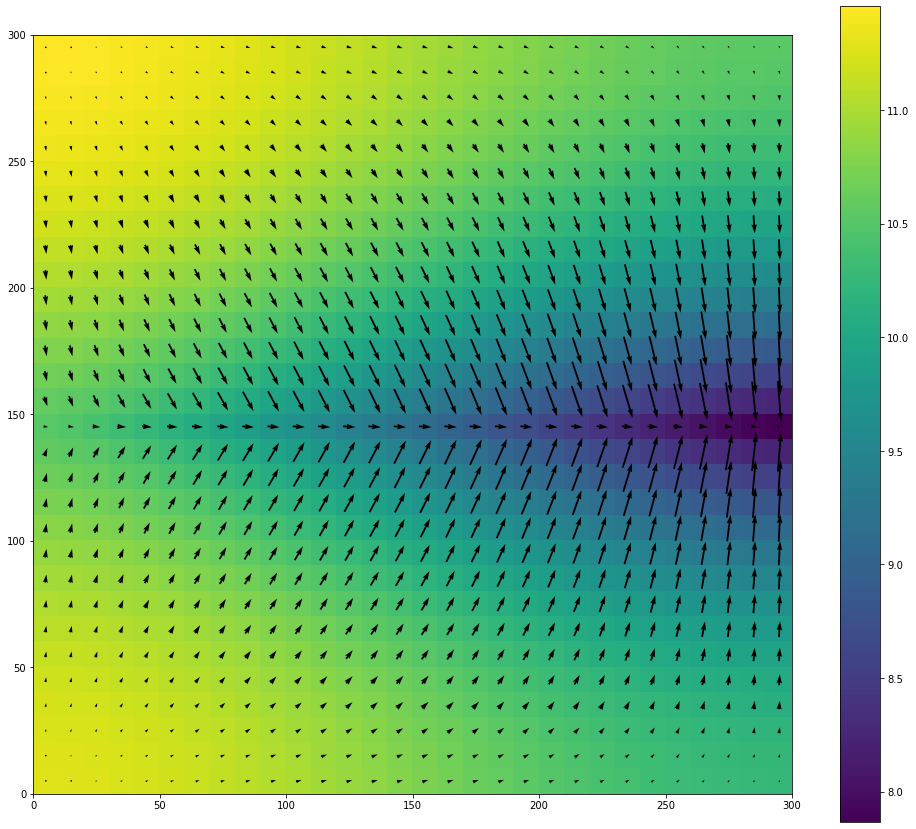

In [11]:
fig = plt.figure(figsize=(17,15))
layer = 0
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)
hmesh=ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
plt.colorbar(hmesh)
ml.plot_specific_discharge(spdis)



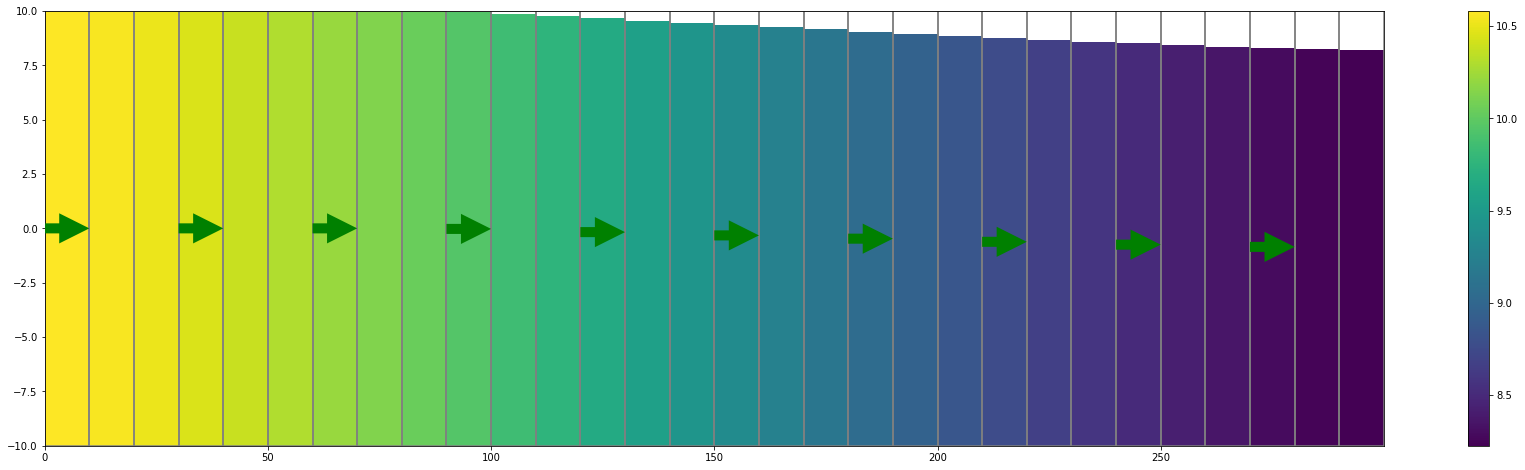

In [12]:
fig,ax = plt.subplots(figsize=(30,8))
x=fp.plot.PlotCrossSection(gwf,line={"row" :16})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
x.plot_ibound()
x.plot_grid()
uiver = x.plot_specific_discharge(spdis, head=head, 
                                       hstep=3, normalize=True, color='green', 
                                       scale=30, headwidth=3, headlength=3, headaxislength=3,
                                       zorder=10)

In [13]:
get_Total_Budget(model_name,model_dir,kstpkper=(0,0))

,Pack,IN,OUT,Type
0,RCHA,0.027,0.000000,RCH
1,SFR,0.000,0.027023,SFR


In [17]:
cbc = get_cbc(model_name,model_dir)

In [18]:
sfrcbc = fp.utils.CellBudgetFile("workspace/test_SFR.sfr.cbc",precision="double")

In [24]:
#retrieve stage infos in lst file
def get_sfr_stages(model_name,model_dir,kstpkper=(0,0)):
    file_p = os.path.join(model_dir,"{}.lst".format(model_name))

    with open(file_p) as f:
        i=-1
        doc = f.readlines()
        tmstp=0;sp=0;inf=0

        for ilin in doc:
            i += 1
            if i == 209:
                break
            try:
                tmstp = int(ilin[39:-1])
                sp = int(ilin[25:33])
                inf = ilin[1:16]
            except:
                pass
            if (inf == "SFR (SFR) STAGE")& (tmstp == kstpkper[0]) + 1 & (sp == kstpkper[1]+1):
                break

        ##nsfrcells


        ##
        stages=[]
        reachno=[]
        rdepth=[]
        for ipak in range(30):
            ipak+=5
            stages.append(doc[i+ipak][30:35])
            reachno.append(int(doc[i+ipak][1:7]))
            rdepth.append(float(doc[i+ipak][41:46]))

    dic={"reach n°":reachno,"stages":stages,"rdepth":rdepth}
    return pd.DataFrame(dic)

In [25]:
get_sfr_stages(model_name,model_dir)

,reach n°,stages,rdepth
0,1,10.29,1.292
1,2,10.15,1.292
2,3,10.02,1.292
3,4,9.878,1.292
4,5,9.740,1.292
5,6,9.602,1.292
6,7,9.464,1.292
7,8,9.327,1.292
8,9,9.189,1.292
9,10,9.051,1.292
